# ML_Cтратегия удержания клиентов в сети фитнес-центров

**Описание проекта**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

**Цели исследования:**
1. Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. Проанализировать основные признаки, наиболее сильно влияющие на отток;
4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
* 1) выделить целевые группы клиентов;
* 2) предложить меры по снижению оттока;
* 3) определить другие особенности взаимодействия с клиентами.

**Ход исследования:**

Моё исследование пройдет в несколько этапов:
* Загружу данные, файл '/datasets/gym_churn.csv' - данные клиента на месяц до оттока и факт оттока на определённый месяц, информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
* Обзор данных, посмотрю их качество
* Предобработка данных (проверка типов данных, проверка на пропуски и их заполнение или удаление, проверка категориальных значений, проверка на аномальные значения, проверка на дубликаты)
* Расчеты и добавление новых столбцов-результатов в таблицы
* Проведение анализа по целям исследования
* Написание общего вывода

### **Описание данных**

**Описание данных**

Датасет '/datasets/gym_churn.csv':

**Данные клиента за предыдущий до проверки факта оттока месяц:**
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

## 1. Загрузка данных

### 1.1 Импортируем библиотеки, откроем csv

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
# magic function, отображает фигуру в блокноте рядом с кодом:
%matplotlib inline
# matplotlib/plot, графики с высоким разрешением:
%config InlineBackend.figure_format='retina'

import seaborn as sns
# применяем стиль whitegrid
# sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# кластеризщация:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
# для графиков попарных сочетаний признаков с разметкой по кластерам
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
# откроем файл *.csv
try:
    try:        
        gym_churn = pd.read_csv('gym_churn.csv')
    except:
        gym_churn = pd.read_csv('/datasets/gym_churn.csv')
except:
    from google.colab import drive
    drive.mount('/content/drive')
    gym_churn = pd.read_csv('/datasets/gym_churn.csv')

### 1.2 Основная информация о дф, краткие хар-ки

In [3]:
# выведем несколько строчек транспонированных
display(gym_churn.head(2).T)
# выведем инфо о дф с типами данных
gym_churn.info()

,0,1
gender,1.000000,0.000000
Near_Location,1.000000,1.000000
Partner,1.000000,0.000000
Promo_friends,1.000000,0.000000
Phone,0.000000,1.000000
Contract_period,6.000000,12.000000
Group_visits,1.000000,1.000000
Age,29.000000,31.000000
Avg_additional_charges_total,14.227470,113.202938
Month_to_end_contract,5.000000,12.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропусков нет, преобразовывать типы данных не надо. Красота

In [4]:
# разделим на 2дф:
# количественные признаки
gym_churn_quantity = gym_churn[['Age',
                              'Avg_additional_charges_total',
                              'Month_to_end_contract',
                              'Lifetime',
                              'Avg_class_frequency_total',
                              'Avg_class_frequency_current_month']]

# категориальные признаки
gym_churn_cat = gym_churn[['gender',
                          'Near_Location',
                          'Partner',
                          'Promo_friends',
                          'Phone',
                          'Contract_period',
                          'Group_visits',
                          'Churn']]

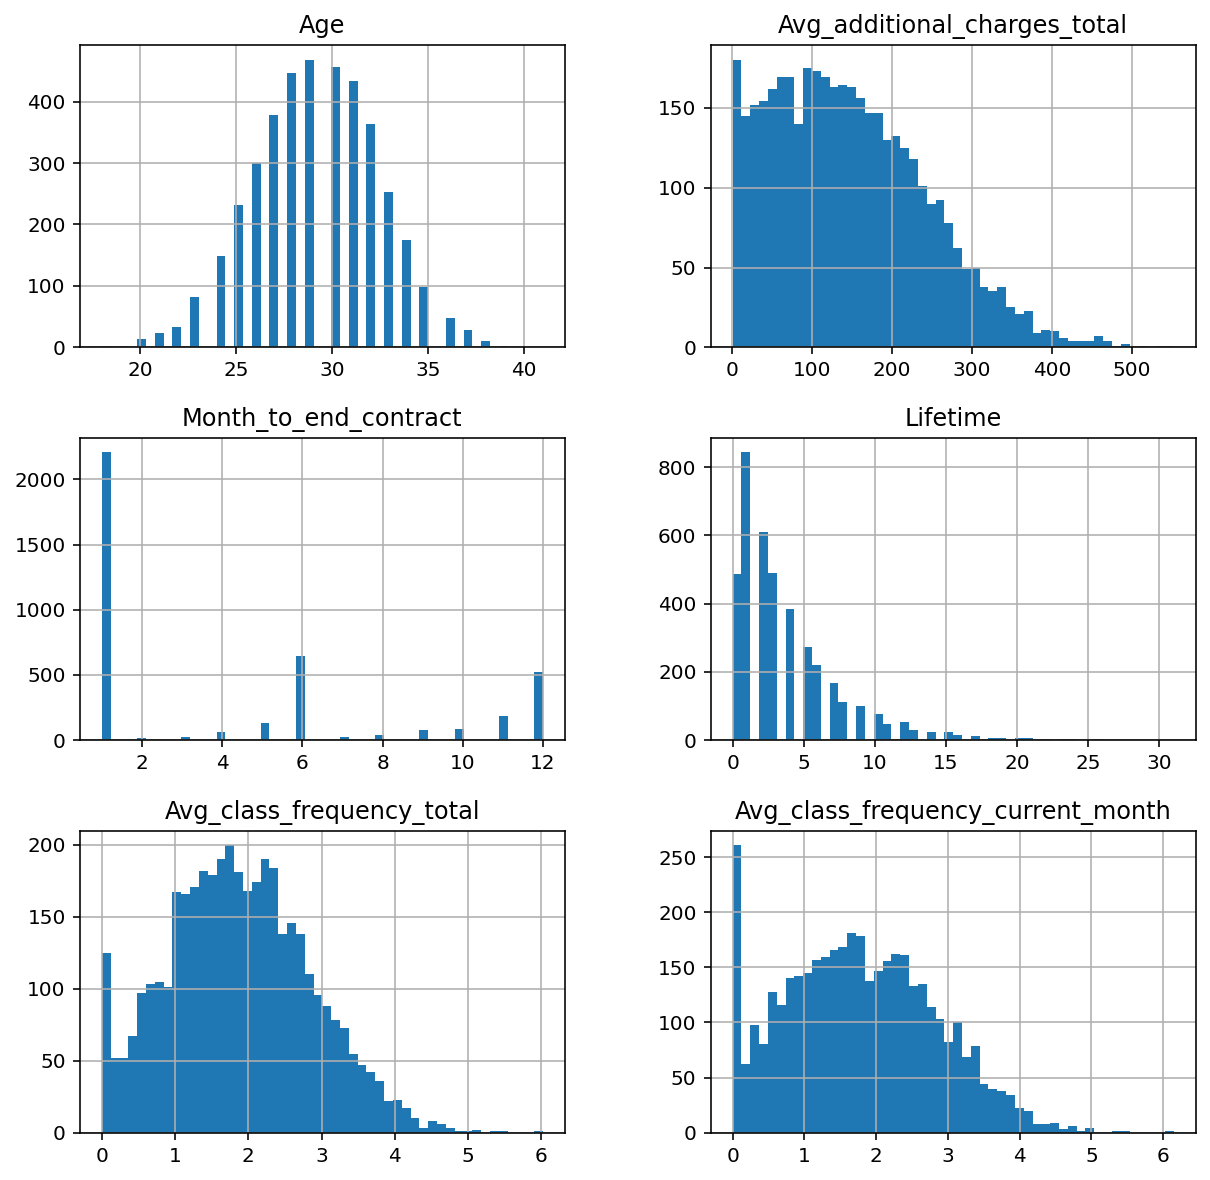

In [5]:
# количественные признаки, распределение
gym_churn_quantity.hist(bins=50, figsize=(10,10))
plt.show()

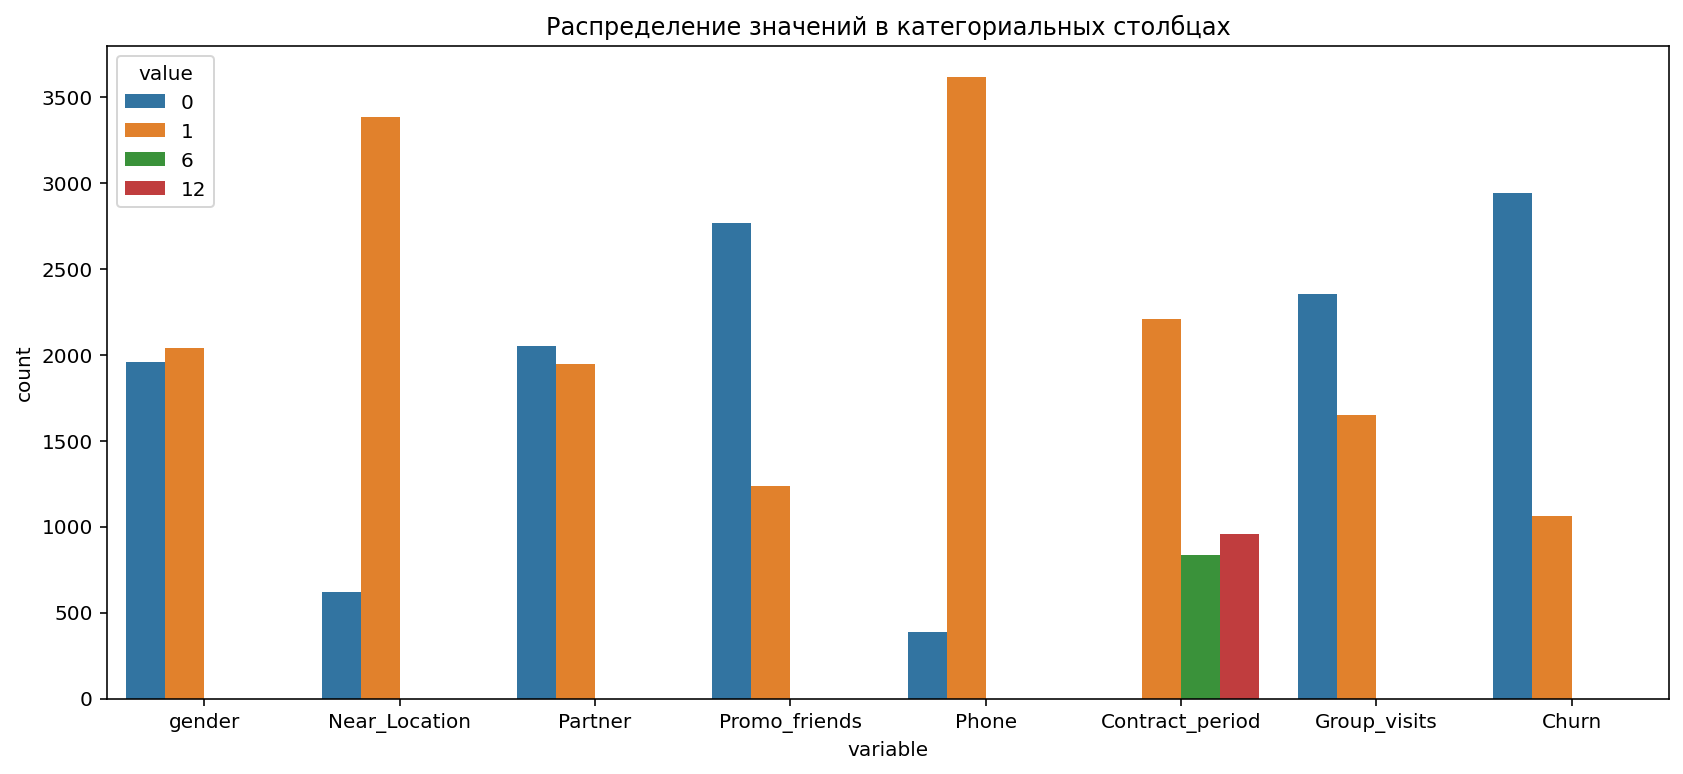

In [6]:
# категориальные признаки, распределение
# melt() соединяем все столбцы в 2 столбца для 1 графика
sns.countplot(data=gym_churn_cat.melt(), x="variable", hue="value")
plt.gcf().set_size_inches(14, 6)  # размер фигуры
plt.title('Распределение значений в категориальных столбцах')
plt.show()

In [7]:
# посмотрим хар-ки выборки: среднее, медианное, разброс
round(gym_churn.describe(), 2)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Краткие выводы:
- М/Ж поровну практически 50/50
- Очень большая часть клиентов 85% проживает или работает в районе, где находится фитнес-центр;
- Клинетов от компании-партнёров -50/50 распределение
- Людей которые пришли по акции «приведи друга» их примерно 1/3
- Телефон указан у большинства 90%
- Возраст нормально распределен, среднее - 29лет
- 'Lifetime' Время жизни клиента (в месяцах) - распределние ближе к 0-1
- 'Contract_period' — длительность текущего действующего абонемента (месяц - почти половина берут на 1мес, 6 месяцев-~25%, год -~25%);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах). Много у кого заканчивается абонемент кумулятивно, это логично потому что есть спуски после 1 и 6 месяцев. Если у большинства абонемент на 1мес то на этом графике их тоже большинство.
- 'Group_visits' — факт посещения групповых занятий ~40%
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента - Среднее 1,88раза в неделю, но визуально еще видно отдельный столбик тех у кого 0 раз.
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц. Тут график похож на предыдущий Тотал, но тут более ярко-выраженная категория людей у которых 0 посещений за месяц.
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон. Смещение к 130-140
- 'Churn' — факт оттока в текущем месяце. ~27%

## 2. Предобработка данных

### 2.1. Преобразуем типы данных

Судя по info Пропусков нет, преобразовывать типы данных не надо. Красота

### 2.2. Проверка на дубликаты и качество данных

Тут нет уникальных id, поэтому проверить на дубликаты невозможно, надо довериться заказчику

In [8]:
# можно только проверить на уникальность строк, нет ли дулирующих
# полные дубликаты
gym_churn.duplicated().sum()

0

Полных дубликатов тоже нет.

## 3. Исследовательский анализ данных (EDA)

### 3.1. Посмотрим средния значения признаков в 2ух группах: кто ушел и кто остался

In [9]:
# сгруппируем по Факту оттока в тек месяце и посмотрим средние
gc_gr = gym_churn.groupby('Churn').mean().T
gc_gr.style.background_gradient(cmap='Oranges', high = 1.5, axis=1)

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


Более подробно рассмотрено ниже в распределениях

### 3.2 Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

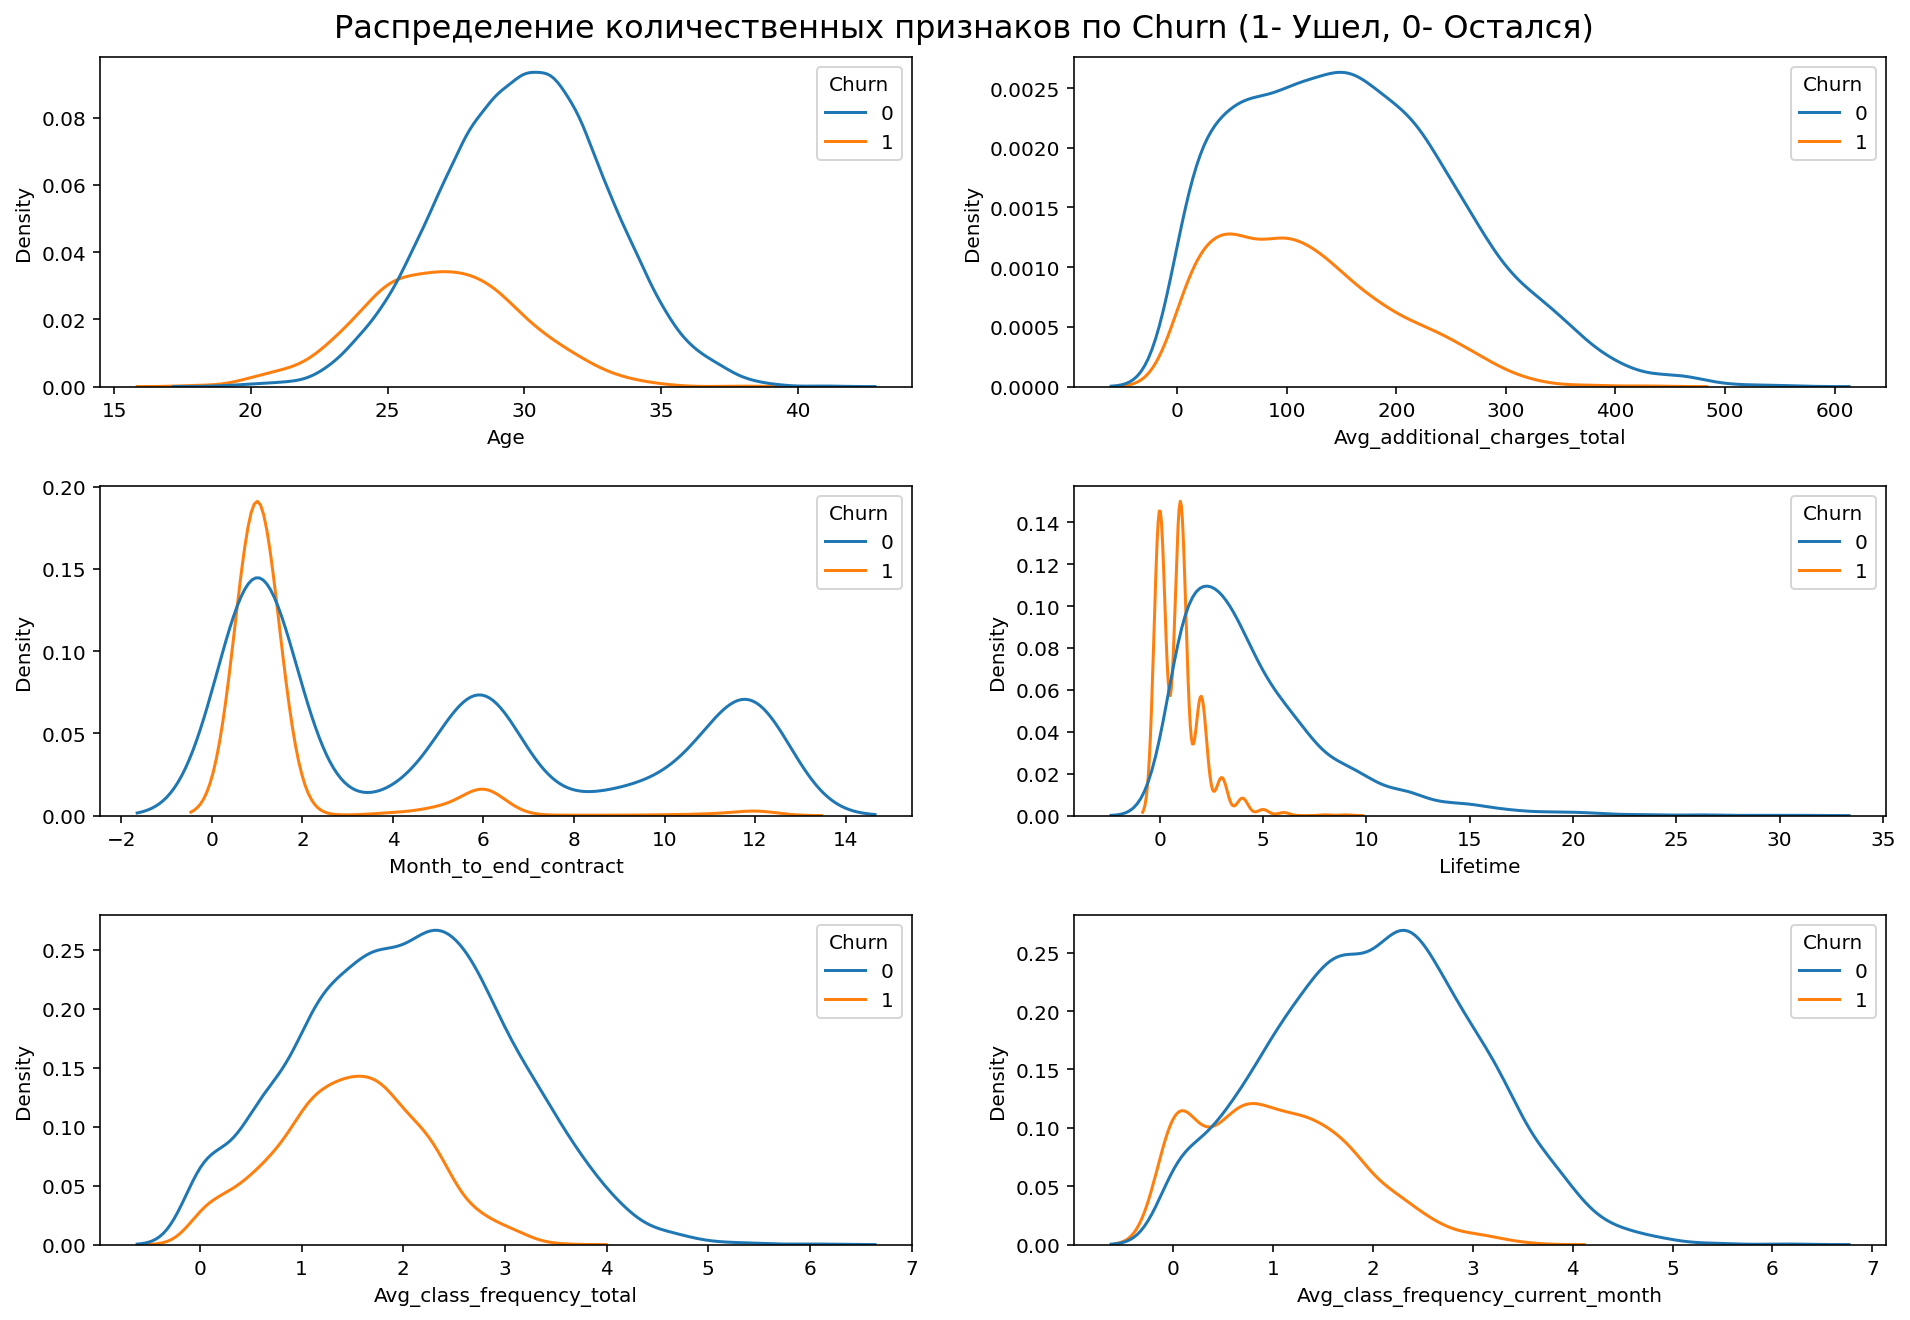

In [10]:
# распределение количественных признаков по Churn

# количественные признаки c Churn
gym_churn_quantity_2 = gym_churn[['Age',
                              'Avg_additional_charges_total',
                              'Month_to_end_contract',
                              'Lifetime',
                              'Avg_class_frequency_total',
                              'Avg_class_frequency_current_month',
                              'Churn']]

# числа строк и столбцов в матрице subplot
num_features = len(gym_churn_quantity_2.columns[:-1])  # Количество признаков
num_cols = 2
num_rows = (num_features + num_cols - 1) // num_cols  # Рассчитываем количество строк

# матрица subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.3, top=0.95)

# Перебор признаков и построение графиков boxplot с использованием hue
for i, column in enumerate(gym_churn_quantity_2.columns[:-1]):  # Исключаем последний столбец
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.kdeplot(data=gym_churn_quantity_2, x=column, hue='Churn', palette='tab10', ax=ax)
    #ax.set_title(f'{column}')
fig.suptitle('Распределение количественных признаков по Churn (1- Ушел, 0- Остался)', fontsize=16)
plt.show()

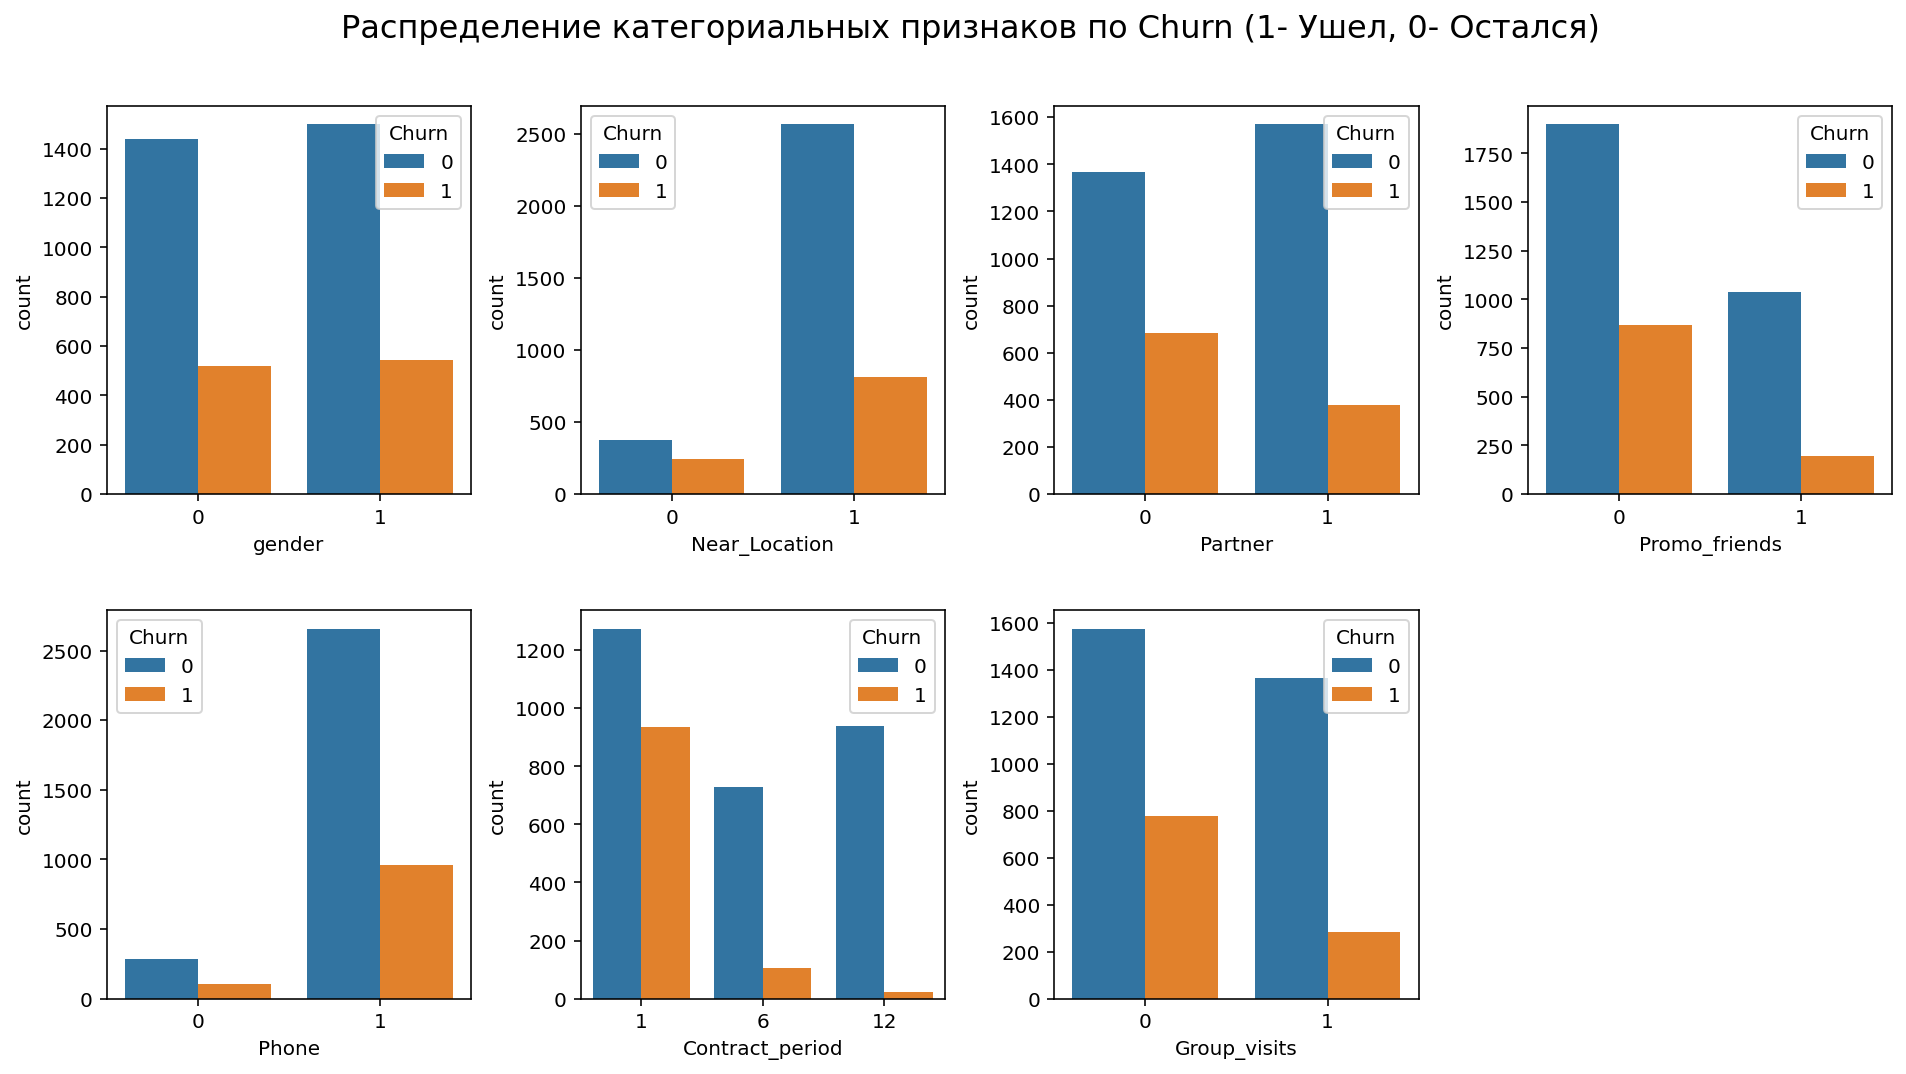

In [11]:
# распределение категориальных признаков по Churn

# числа строк и столбцов в матрице subplot
num_features = len(gym_churn_cat.columns[:-1])  # Количество признаков
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols  # Рассчитываем количество строк

# матрица subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9)

# Перебор признаков и построение графиков boxplot с использованием hue
for i, column in enumerate(gym_churn_cat.columns[:-1]):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.countplot(data=gym_churn_cat, x=column, hue='Churn', palette='tab10', ax=ax)
    #ax.set_title(f'{column}')
# # удалим лишние пустые графики
# # диапазон кол-во пар - ШхВ граифков
for i in range(num_features, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

fig.suptitle('Распределение категориальных признаков по Churn (1- Ушел, 0- Остался)', fontsize=16)
plt.show()

Характерные признаки клиентов, у кого факт оттока есть (1), среди них:
- Меньшее кол-во людей которые от компаний-партнеров
- Меньшее кол-во людей которые пришли по акции "приведи друга"
- Маленькая длительность абонемента, близко к 1мес (что логично)
- Мало ходят на групповые занятия
- Малый "Лайфтайм", время жизни клиента
- Меньшее кол-во посещения за последний месяц

### 3.3 Построим матрицу корреляций

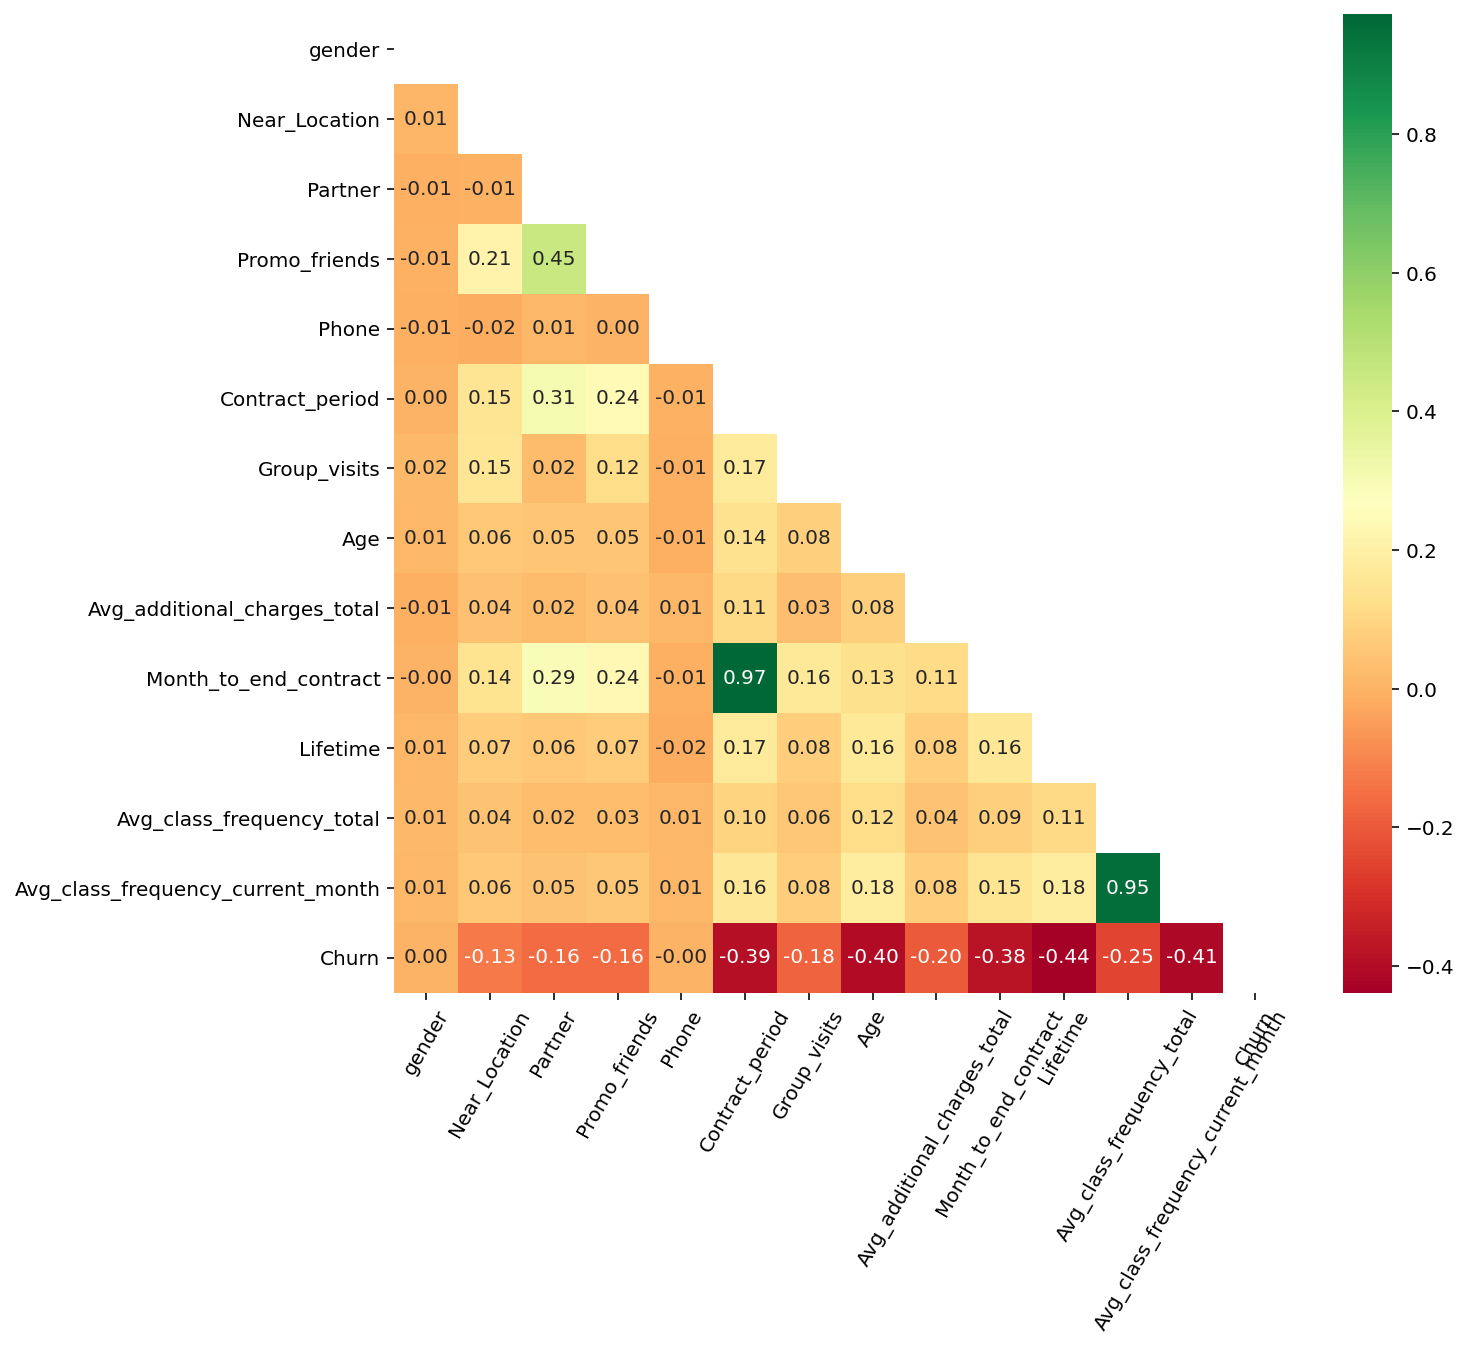

In [12]:
# корреляция стандартная Пирсона (линейная корелляция)
plt.figure(figsize=(10,9))
sns.heatmap(gym_churn.corr(), annot=True, cmap='RdYlGn', fmt='.2f',
            mask=np.triu(gym_churn.corr())) # .2f-2цифры
plt.xticks(rotation=60)
plt.show()

Выводы по матрице корелляций
1. Есть два пересечения сильно-кореллированных признаков (мультиколлениарность), которые > 0,9:
    1) Сроки абонемента/ длительность остатка (0.97):
    - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    2) Частота посещений за неделю за все время/ за последний месяц (0.95):
    - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
2. Умеренная корелляция есть у факта Оттока Churn c: Периодом абонемента, Сколько осталось месяцев по абонементу, Возрастом, Лайфтайм клиента, Сколько он ходил часов за неделю в последний месяц, Промо акция - Партнерская программа.
3. Близко к 0 корелляциия у Пола, Указание телефона - практически не кореллирует линейно ни с каким признаком. Но может быть там не линейная связь, которую пирсон не может выявить.
4. У остальных признаков слабая линейная корреляция.

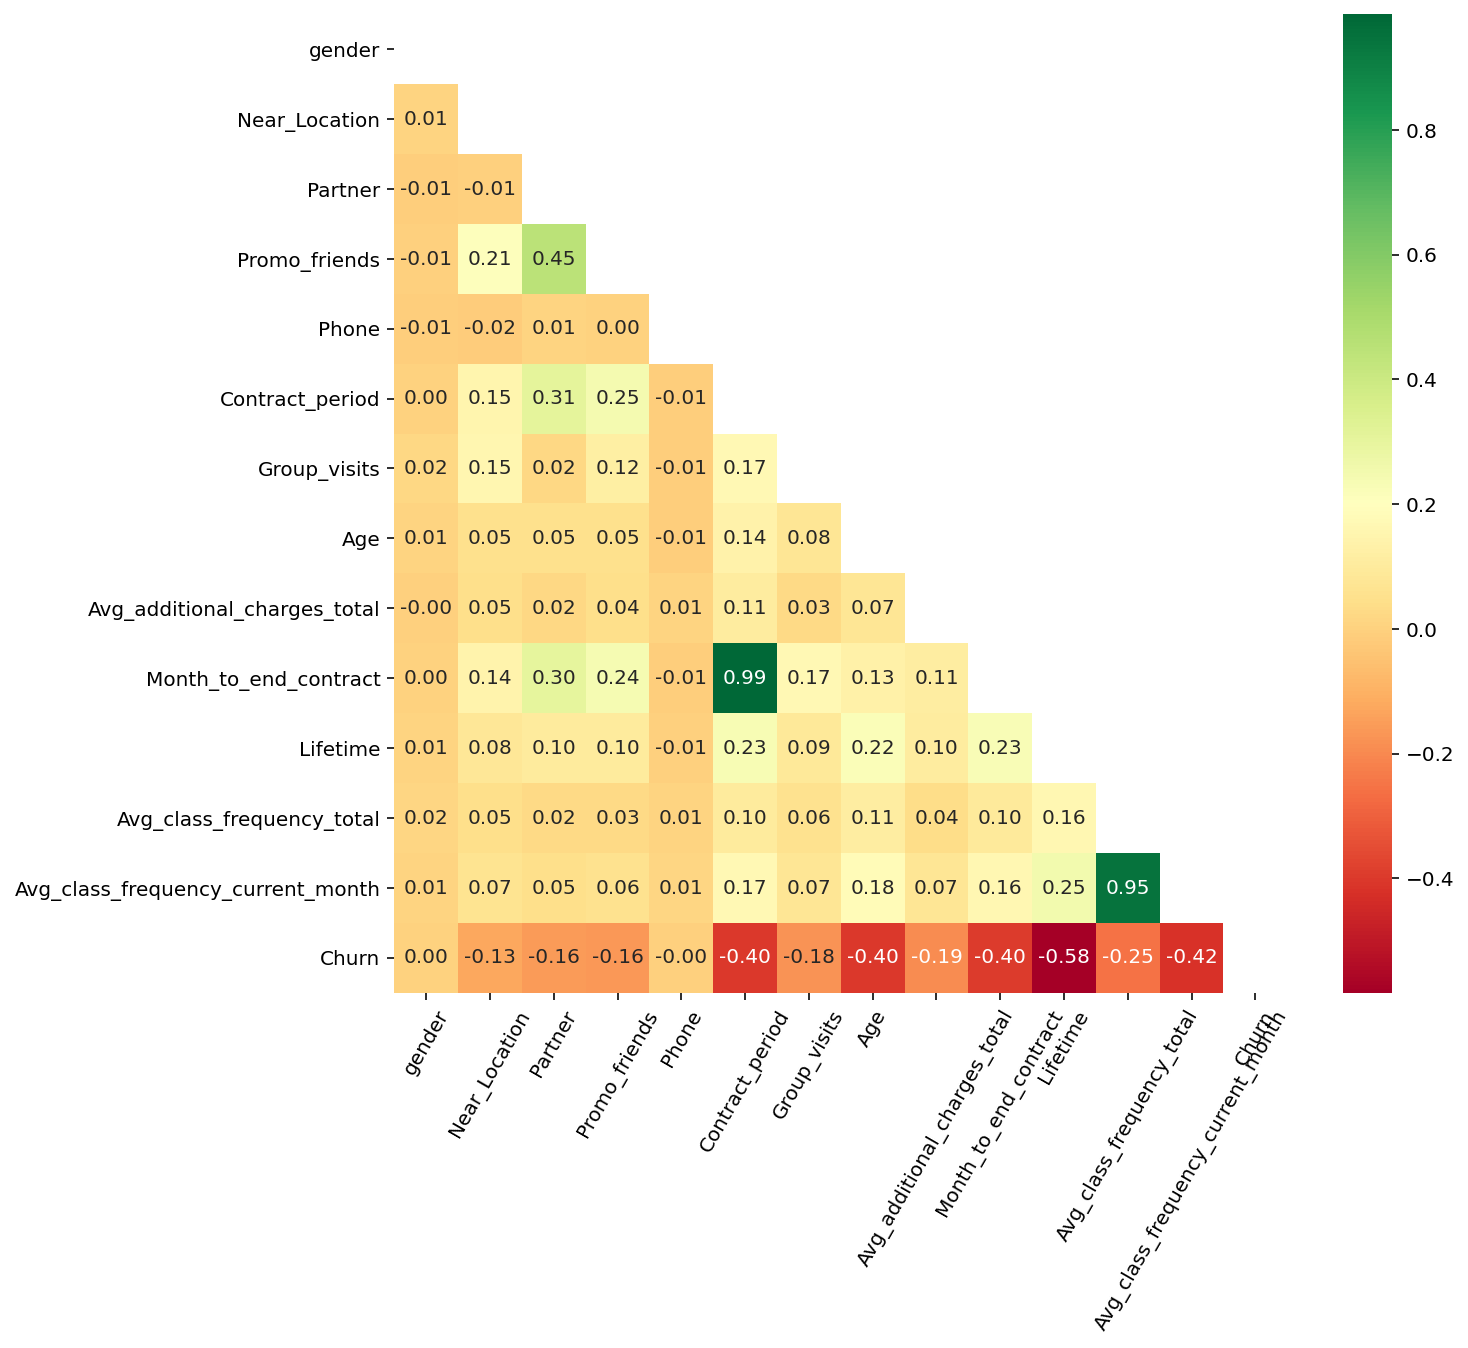

In [13]:
# для категориальных числовых значений корреляция Спирмена
plt.figure(figsize=(10,9))
sns.heatmap(gym_churn.corr(method='spearman'), annot=True, cmap='RdYlGn', fmt='.2f',
            mask=np.triu(gym_churn.corr())) # .2f-2цифры
plt.xticks(rotation=60)
plt.show()

Корелляция по Спирмену почти не отличается.

Сильно-кореллированные признаки это плохо. Протестируем модель с скоррелированными признаками и без них (удалим), и потом сравним модели. Случайный лес не страдает от скоррелированных признаков, но обучение будет длиться дольше и сложнее будет интерпретировать результаты.

In [14]:
# оставим дф без кореллируемых признаков
# протестируем 4 варианта (итог теста: с их удалением только хуже коэф-ты, в итоне не используем дф gym_churn_noncorr)
#gym_churn_noncorr = gym_churn.drop(columns= ['Month_to_end_contract', 'Avg_class_frequency_total'])
#gym_churn_noncorr = gym_churn.drop(columns= ['Month_to_end_contract', 'Avg_class_frequency_current_month'])
#gym_churn_noncorr = gym_churn.drop(columns= ['Contract_period', 'Avg_class_frequency_total'])
gym_churn_noncorr = gym_churn.drop(columns= ['Contract_period', 'Avg_class_frequency_current_month'])

## 4. Модель прогнозирования оттока клиентов
Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

### 4.1 DF c скоррелированными признаками. Модели: Логистическая регрессия, Случайный лес


In [15]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop(columns=['Churn'])
y = gym_churn['Churn']

#разделяем модель на обучающую и валидационную выборки
# stratify=y Стратификация (равномерное распределение), улучшает метрики
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y)

In [16]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()

# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train)
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [17]:
# задаем модель логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# прогноз обученной моделью
predictions = lr_model.predict(X_test_st)

# выведем все изученные метрики
print('Метрики Логистической регрессии:')
print('Accuracy (Доля правильных ответов): {:.3f}'.format(accuracy_score(y_test, predictions)))
print('Precision (Точность): {:.3f}'.format(precision_score(y_test, predictions)))
print('Recall (Полнота): {:.3f}'.format(recall_score(y_test, predictions)))
print('F1 (Мера, баланс между метриками): {:.3f}'.format(f1_score(y_test, predictions)))

# из вектора пар вероятностей отнесения объекта к классу "0" и "1"
# берем лишь вторые числа
probabilities = lr_model.predict_proba(X_test_st)[:,1]
# выведем roc_auc_score
print('ROC_AUC (Площадь под кривой): {:.3f}'.format(roc_auc_score(y_test, probabilities)))

Метрики Логистической регрессии:
Accuracy (Доля правильных ответов): 0.935
Precision (Точность): 0.896
Recall (Полнота): 0.854
F1 (Мера, баланс между метриками): 0.874
ROC_AUC (Площадь под кривой): 0.978


In [18]:
# задаем модель Случайный лес, n_estimators — число деревьев
# max_depth после 20 ничего не меняется.
# попробуем поперебирать n_estimators, я уже прогнал и ограничил диапазон

print('Метрики Случайного леса (перебор n_estimators):')
for i in range(160,178):
    rfr_model = RandomForestClassifier(n_estimators = i, max_depth=20, random_state=0)

    # обучим модель
    rfr_model.fit(X_train_st, y_train)

    # прогноз обученной моделью
    predictions = rfr_model.predict(X_test_st)

    # выведем Accuracy
    print(f'{i}: Accuracy (Доля правильных ответов): {accuracy_score(y_test, predictions):.3f}')

Метрики Случайного леса (перебор n_estimators):
160: Accuracy (Доля правильных ответов): 0.925
161: Accuracy (Доля правильных ответов): 0.925
162: Accuracy (Доля правильных ответов): 0.925
163: Accuracy (Доля правильных ответов): 0.926
164: Accuracy (Доля правильных ответов): 0.926
165: Accuracy (Доля правильных ответов): 0.926
166: Accuracy (Доля правильных ответов): 0.926
167: Accuracy (Доля правильных ответов): 0.926
168: Accuracy (Доля правильных ответов): 0.926
169: Accuracy (Доля правильных ответов): 0.926
170: Accuracy (Доля правильных ответов): 0.926
171: Accuracy (Доля правильных ответов): 0.926
172: Accuracy (Доля правильных ответов): 0.927
173: Accuracy (Доля правильных ответов): 0.926
174: Accuracy (Доля правильных ответов): 0.926
175: Accuracy (Доля правильных ответов): 0.926
176: Accuracy (Доля правильных ответов): 0.925
177: Accuracy (Доля правильных ответов): 0.925


In [19]:
#2 задаем модель Случайный лес, n_estimators — число деревьев
# max_depth после 20 ничего не меняется, n_estimators оптимально ..
rfr_model = RandomForestClassifier(n_estimators = 172, max_depth=20, random_state=0)

# обучим модель
rfr_model.fit(X_train_st, y_train)

# прогноз обученной моделью
predictions = rfr_model.predict(X_test_st)

# выведем все изученные метрики
print('Метрики Случайного леса:')
print('Accuracy (Доля правильных ответов): {:.3f}'.format(accuracy_score(y_test, predictions)))
print('Precision (Точность): {:.3f}'.format(precision_score(y_test, predictions)))
print('Recall (Полнота): {:.3f}'.format(recall_score(y_test, predictions)))
print('F1 (Мера, баланс между метриками): {:.3f}'.format(f1_score(y_test, predictions)))

# из вектора пар вероятностей отнесения объекта к классу "0" и "1"
# берем лишь вторые числа
probabilities = rfr_model.predict_proba(X_test_st)[:,1]
# выведем roc_auc_score
print('ROC_AUC (Площадь под кривой): {:.3f}'.format(roc_auc_score(y_test, probabilities)))

Метрики Случайного леса:
Accuracy (Доля правильных ответов): 0.927
Precision (Точность): 0.881
Recall (Полнота): 0.840
F1 (Мера, баланс между метриками): 0.860
ROC_AUC (Площадь под кривой): 0.971


### 4.2 DF БЕЗ скоррелированных признаков (удалены). Модели: Логистическая регрессия, Случайный лес

In [20]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X2 = gym_churn_noncorr.drop(columns=['Churn'])
y2 = gym_churn_noncorr['Churn']

#разделяем модель на обучающую и валидационную выборки
# stratify=y Стратификация (равномерное распределение), улучшает метрики
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=0, stratify=y)

In [21]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler2 = StandardScaler()

# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st2 = scaler2.fit_transform(X_train2)  # или надо просто .transform?
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st2 = scaler2.transform(X_test2)

In [22]:
# задаем модель логистической регрессии2 без скоррелированных признаков
lr_model2 = LogisticRegression(solver='liblinear')

# обучим модель
lr_model2.fit(X_train_st2, y_train2)

# прогноз обученной моделью
predictions2 = lr_model2.predict(X_test_st2)

# выведем все изученные метрики
print('Метрики Логистической регрессии:')
print('Accuracy (Доля правильных ответов): {:.3f}'.format(accuracy_score(y_test2, predictions2)))
print('Precision (Точность): {:.3f}'.format(precision_score(y_test2, predictions2)))
print('Recall (Полнота): {:.3f}'.format(recall_score(y_test2, predictions2)))
print('F1 (Мера, баланс между метриками): {:.3f}'.format(f1_score(y_test2, predictions2)))

# из вектора пар вероятностей отнесения объекта к классу "0" и "1"
# берем лишь вторые числа
probabilities2 = lr_model2.predict_proba(X_test_st2)[:,1]
# выведем roc_auc_score
print('ROC_AUC (Площадь под кривой): {:.3f}'.format(roc_auc_score(y_test2, probabilities2)))

Метрики Логистической регрессии:
Accuracy (Доля правильных ответов): 0.902
Precision (Точность): 0.813
Recall (Полнота): 0.821
F1 (Мера, баланс между метриками): 0.817
ROC_AUC (Площадь под кривой): 0.959


In [23]:
# нет смысла в переборе, сэкономим время
# и так и так без скореллированных признаков хуже прозноз

# # задаем модель Случайный лес, n_estimators — число деревьев
# # max_depth после 20 ничего не меняется.
# # попробуем поперебирать n_estimators, я уже прогнал, огр диапазон

# print('Метрики Случайного леса (перебор n_estimators):')
# for i in range(150,200):
#     rfr_model2 = RandomForestClassifier(n_estimators = i, max_depth=20, random_state=0)

#     # обучим модель
#     rfr_model2.fit(X_train_st2, y_train2)

#     # прогноз обученной моделью
#     predictions2 = rfr_model2.predict(X_test_st2)

#     # выведем Accuracy
#     print(f'{i}: Accuracy (Доля правильных ответов): {accuracy_score(y_test2, predictions2):.3f}')

In [24]:
#2 задаем модель Случайный лес без скоррелированных признаков, n_estimators — число деревьев
# max_depth после 20 ничего не меняется, n_estimators оптимально ..
rfr_model2 = RandomForestClassifier(n_estimators = 172, max_depth=20, random_state=0)

# обучим модель
rfr_model2.fit(X_train_st2, y_train2)

# прогноз обученной моделью
predictions2 = rfr_model2.predict(X_test_st2)

# выведем все изученные метрики
print('Метрики Случайного леса:')
print('Accuracy (Доля правильных ответов): {:.3f}'.format(accuracy_score(y_test2, predictions2)))
print('Precision (Точность): {:.3f}'.format(precision_score(y_test2, predictions2)))
print('Recall (Полнота): {:.3f}'.format(recall_score(y_test2, predictions2)))
print('F1 (Мера, баланс между метриками): {:.3f}'.format(f1_score(y_test2, predictions2)))

# из вектора пар вероятностей отнесения объекта к классу "0" и "1"
# берем лишь вторые числа
probabilities2 = rfr_model2.predict_proba(X_test_st2)[:,1]
# выведем roc_auc_score
print('ROC_AUC (Площадь под кривой): {:.3f}'.format(roc_auc_score(y_test2, probabilities2)))

Метрики Случайного леса:
Accuracy (Доля правильных ответов): 0.895
Precision (Точность): 0.820
Recall (Полнота): 0.774
F1 (Мера, баланс между метриками): 0.796
ROC_AUC (Площадь под кривой): 0.946


### 4.3 Оценка метрик: accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнение по ним моделей. Какая модель показала себя лучше на основании метрик?

1. Для бинарной классификации Логистическая регрессия, Случайный лес- не страдают от скоррелированных(мультиколлениарных) признаков, даже наоборот если удалить скореллированные признаки то модель будет хуже предсказывать.
2. Самые лучше метрики получились у Логистической регрессии с добавлением stratify=y Стратификация (равномерное распределение).

- Метрики Логистической регрессии:
- Accuracy (Доля правильных ответов): 0.935
- Precision (Точность): 0.896
- Recall (Полнота): 0.854
- F1 (Мера, баланс между метриками): 0.874
- ROC_AUC (Площадь под кривой): 0.978


- Метрики Случайного леса:
- Accuracy (Доля правильных ответов): 0.927
- Precision (Точность): 0.881
- Recall (Полнота): 0.840
- F1 (Мера, баланс между метриками): 0.860
- ROC_AUC (Площадь под кривой): 0.971


* Метрика Accuracy может быть плохой, если классы в таргете несбалансированы, то модель может иметь высокую точность просто предсказывая большинство клиентов как "оставшиеся", но это не будет информативным решением. А у нас как раз кстати Оттока 1/3.
* Для оценки Accuracy в случае дисбаланса классов, важно использовать дополнительные метрики: Precision, Recall и F1-меру. Они у нас ближе к 1, поэтому в целом хорошая модель вышла.
* Относительно Precision и Recall: Какая метрика более важна зависит от бизнес-контекста. Если более важно избегать ложных положительных прогнозов (ложных тревожных сигналов), то Precision важнее. Если более важно избегать ложных отрицательных прогнозов (пропущенных клиентов, которые уйдут), то Recall важнее. В некоторых случаях, возможно, важно достичь баланса между ними с помощью F1-меры.
* Для нашего случая надо поднимать Recall. Не так страшно, если модель спрогнозирует уход клиента, а после вторичного исследования окажется, что клиент и не собирался уходить, чем если мы пропустим реальный случай ухода, будет гораздо более невыгодно. Если практически, то надо понимать порог классификации (threshold). Однако, при увеличении Recall, может увеличиться количество ложных положительных прогнозов (клиентов, которые были неправильно классифицированы как уходящие). Поэтому важно также следить за Precision и балансировать его.



In [25]:
# Попробуем установить другой порог

# Получение предсказанных вероятностей
predicted_probabilities = lr_model.predict_proba(X_test_st)

# Установка нового порога
threshold_new = 0.3

# Определение классов на основе нового порога
# из вектора пар вероятностей отнесения объекта к классу "0" и "1"
# берем лишь вторые числа
predicted_new = (predicted_probabilities[:, 1] > threshold_new)#.astype(np.int)

# Вычисление метрик с использованием новых классов
print('Метрики Логистической регрессии:')
print('Accuracy (Доля правильных ответов): {:.3f}'.format(accuracy_score(y_test, predicted_new)))
print('Precision (Точность): {:.3f}'.format(precision_score(y_test, predicted_new)))
print('Recall (Полнота): {:.3f}'.format(recall_score(y_test, predicted_new)))
print('F1 (Мера, баланс между метриками): {:.3f}'.format(f1_score(y_test, predicted_new)))

# выведем roc_auc_score
print('ROC_AUC (Площадь под кривой): {:.3f}'.format(roc_auc_score(y_test, predicted_new)))

Метрики Логистической регрессии:
Accuracy (Доля правильных ответов): 0.919
Precision (Точность): 0.798
Recall (Полнота): 0.929
F1 (Мера, баланс между метриками): 0.858
ROC_AUC (Площадь под кривой): 0.922


При threshold_new = 0.3 у нас Recall поднялся с 0.854 до 0.929. Accuracy (доля правильных ответов) снизилась с 0,935 до 0,919, но вроде не страшно.

### 4.4 Признаки, влияющие на важность оттока

In [26]:
# создадим датафреймы с именами признаков и их важностью и выведем его по убыванию важности
# Логистическая регрессия:
coefficients = pd.DataFrame({'feature': X.columns, 'importance': abs(lr_model.coef_[0])})
print('Логистическая регрессия:')
display(coefficients.sort_values(by='importance', ascending=False))

# Случайный лес:
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': rfr_model.feature_importances_})
print('Случайный лес:')
display(feature_importance_df.sort_values(by='importance', ascending=False))

Логистическая регрессия:


,feature,importance
12,Avg_class_frequency_current_month,4.189012
10,Lifetime,3.471939
11,Avg_class_frequency_total,3.105587
7,Age,1.148928
5,Contract_period,0.687710
9,Month_to_end_contract,0.617235
8,Avg_additional_charges_total,0.560866
6,Group_visits,0.393328
3,Promo_friends,0.139599
2,Partner,0.068231


Случайный лес:


,feature,importance
10,Lifetime,0.268341
12,Avg_class_frequency_current_month,0.174319
11,Avg_class_frequency_total,0.134768
7,Age,0.125425
8,Avg_additional_charges_total,0.089507
9,Month_to_end_contract,0.071101
5,Contract_period,0.070482
6,Group_visits,0.015928
0,gender,0.012090
2,Partner,0.011896


У лучшей модели по всем метрикам Логистическая регрессия, самые важные параметры влияющие на отток клиента: 

1. Средняя частота посещений в неделю за предыдущий месяц. 
2. 'Lifetime' — время с момента первого обращения в фитнес-центр 
3. Средняя частота посещений в неделю за все время с начала действия абонемента
* У модели Случайный лес тройка такая же, только порядок немного другой.

## 5. Кластеризация клиентов

### 5.1 Стандартизация, Дендограмма

In [27]:
# стандартизируем данные матрицы X (признаки)
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Построим матрицу расстояний функцией linkage()
linked = linkage(X_sc, method = 'ward') 

А тут надо подождать с дендограммой:

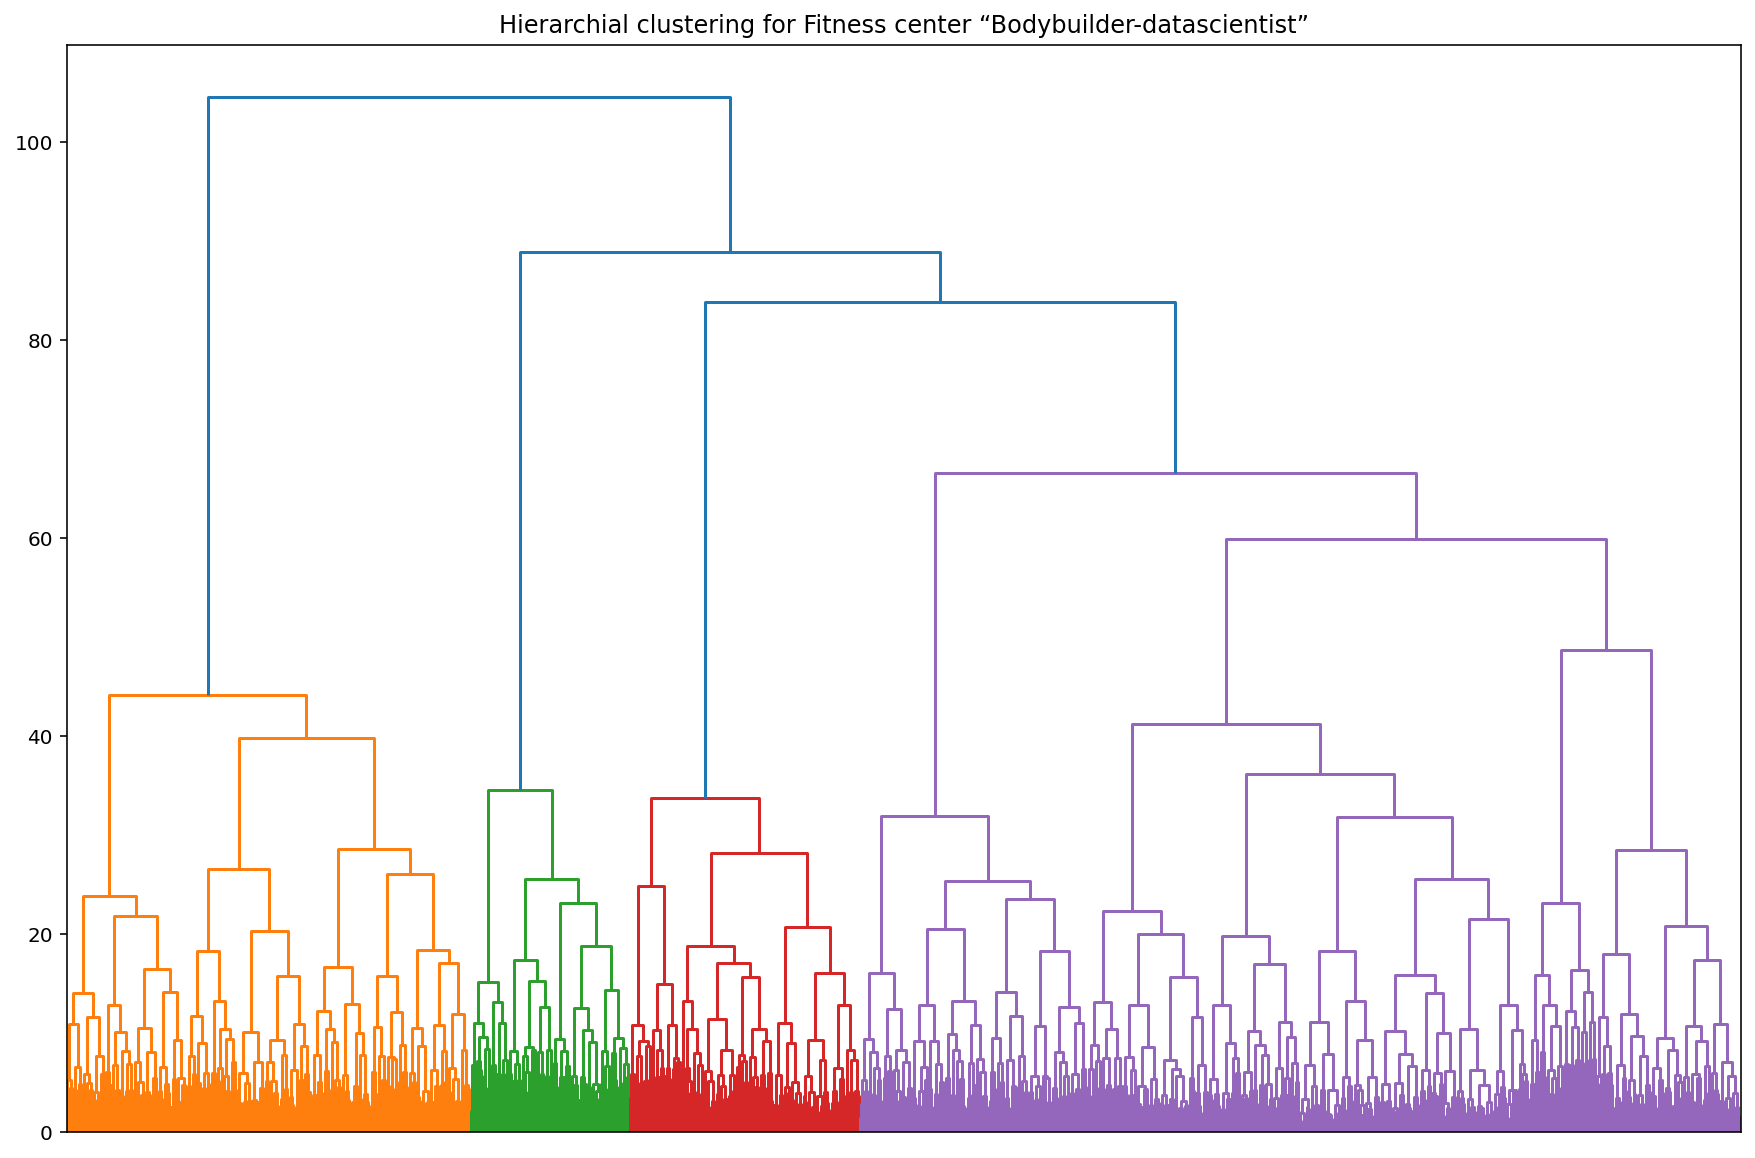

In [28]:
# без отображения индексов дендрограмма быстро рисуется:
# на стандартизованной матрице признаков и нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked,
           orientation='top',
           no_labels=True)
plt.title('Hierarchial clustering for Fitness center “Bodybuilder-datascientist”')
plt.show()

Визуально можно выделить от 4 до 6 кластеров.
В дальнейшем будем использовать число кластеров n=5.

### 5.2 Средняя доля оттока для кластеров

In [29]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
# подкрасим высокие значения, high ограничиваем верх градиента слишком темный
gym_churn_cl = gym_churn.groupby('cluster_km').mean()
gym_churn_cl['cl_count'] = gym_churn.groupby('cluster_km')['cluster_km'].count()
display(gym_churn_cl
        .T
        .style.background_gradient(cmap='Oranges', high = 1, axis=1)
        .set_precision(2))

cluster_km,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
Near_Location,0.96,0.86,0.00,1.00,0.98
Partner,0.78,0.47,0.46,0.35,0.36
Promo_friends,0.57,0.31,0.08,0.24,0.23
Phone,1.00,0.00,1.00,1.00,1.00
Contract_period,10.89,4.79,2.35,1.95,2.67
Group_visits,0.54,0.43,0.22,0.34,0.47
Age,29.98,29.30,28.48,28.17,30.13
Avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
Month_to_end_contract,9.95,4.48,2.20,1.86,2.46


Сделаем выводы по таблице и по парным графикам после графиров.

### 5.3 Кластеры оттока - парные графики признаков

In [30]:
# количественные признаки
gym_churn_quantity_cl = gym_churn[['Age',
                              'Avg_additional_charges_total',
                              'Month_to_end_contract',
                              'Lifetime',
                              'Avg_class_frequency_total',
                              'Avg_class_frequency_current_month',
                              'cluster_km']]

# категориальные признаки
gym_churn_cat_cl = gym_churn[['gender',
                          'Near_Location',
                          'Partner',
                          'Promo_friends',
                          'Phone',
                          'Contract_period',
                          'Group_visits',
                          'Churn',
                          'cluster_km']]

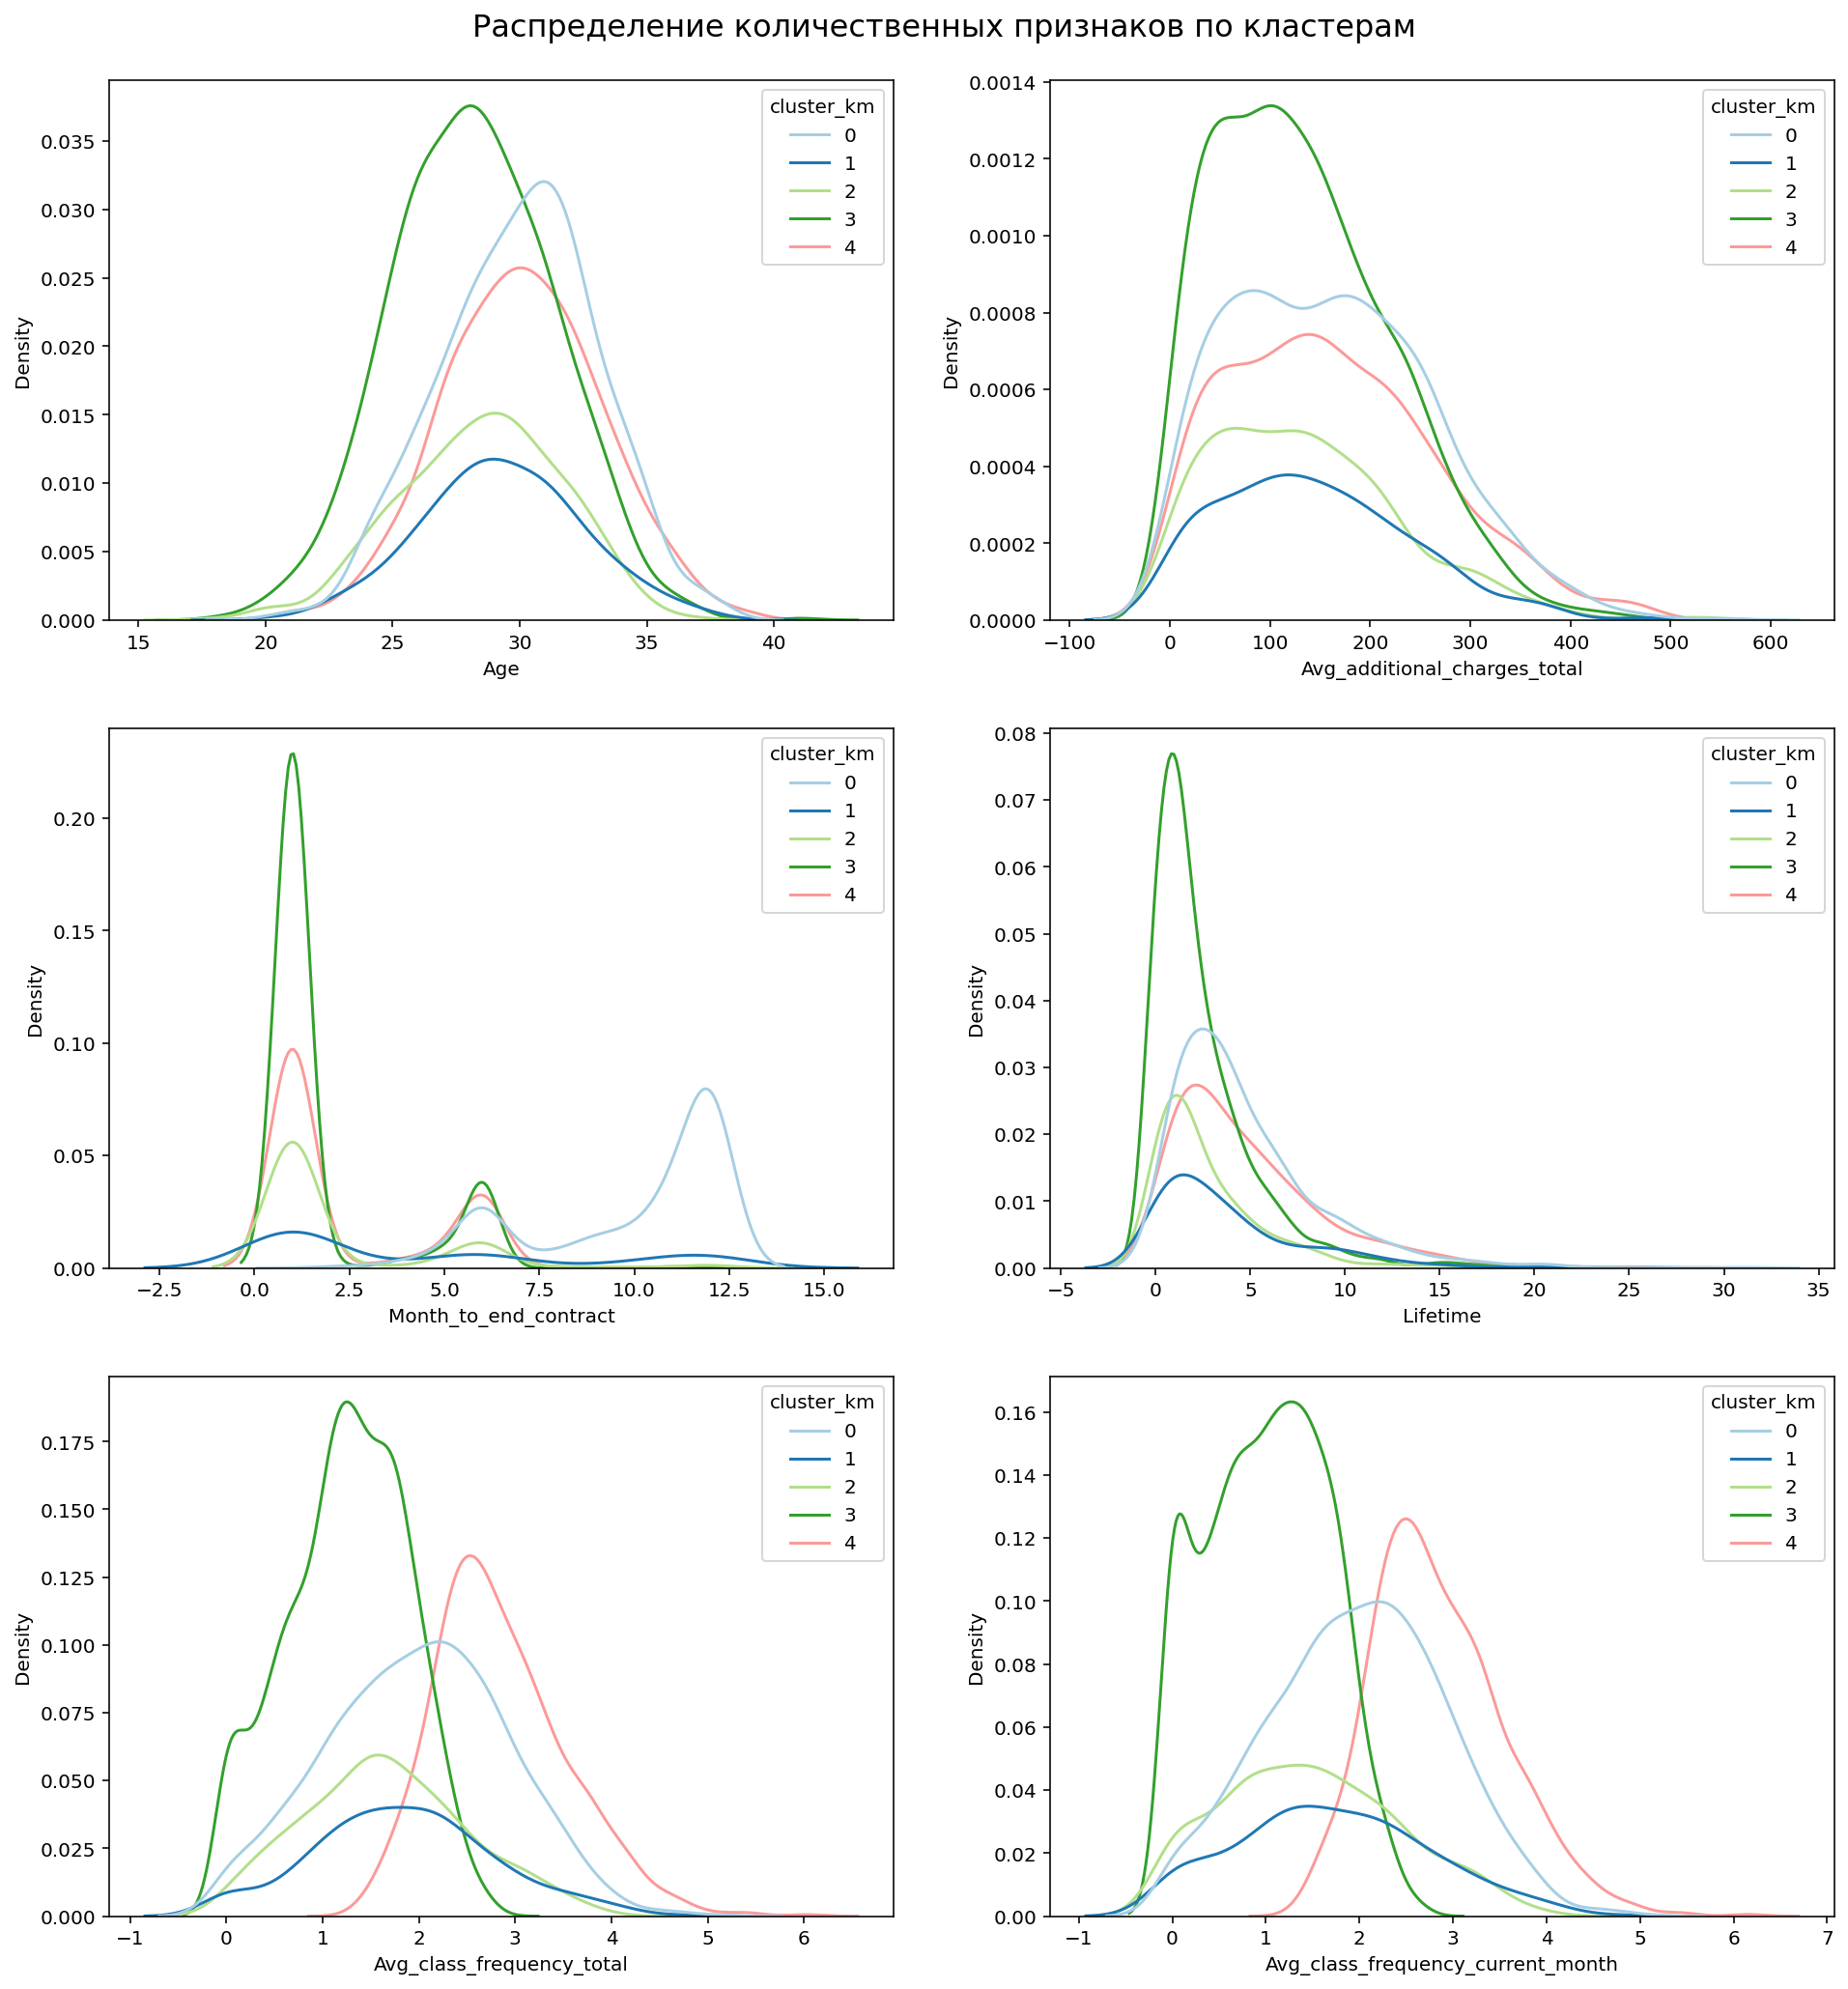

In [31]:
# распределение количественных признаков gym_churn_quantity_cl для кластеров

# числа строк и столбцов в матрице subplot
num_features = len(gym_churn_quantity_cl.columns[:-1])  # Количество признаков
num_cols = 2
num_rows = (num_features + num_cols - 1) // num_cols  # Рассчитываем количество строк

# матрица subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95)

# Перебор признаков и построение графиков boxplot с использованием hue
for i, column in enumerate(gym_churn_quantity_cl.columns[:-1]):  # Исключаем последний столбец с кластерами
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.kdeplot(data=gym_churn_quantity_cl, x=column, hue='cluster_km', palette='Paired', ax=ax)
    #ax.set_title(f'{column}')
fig.suptitle('Распределение количественных признаков по кластерам', fontsize=16)
plt.show()

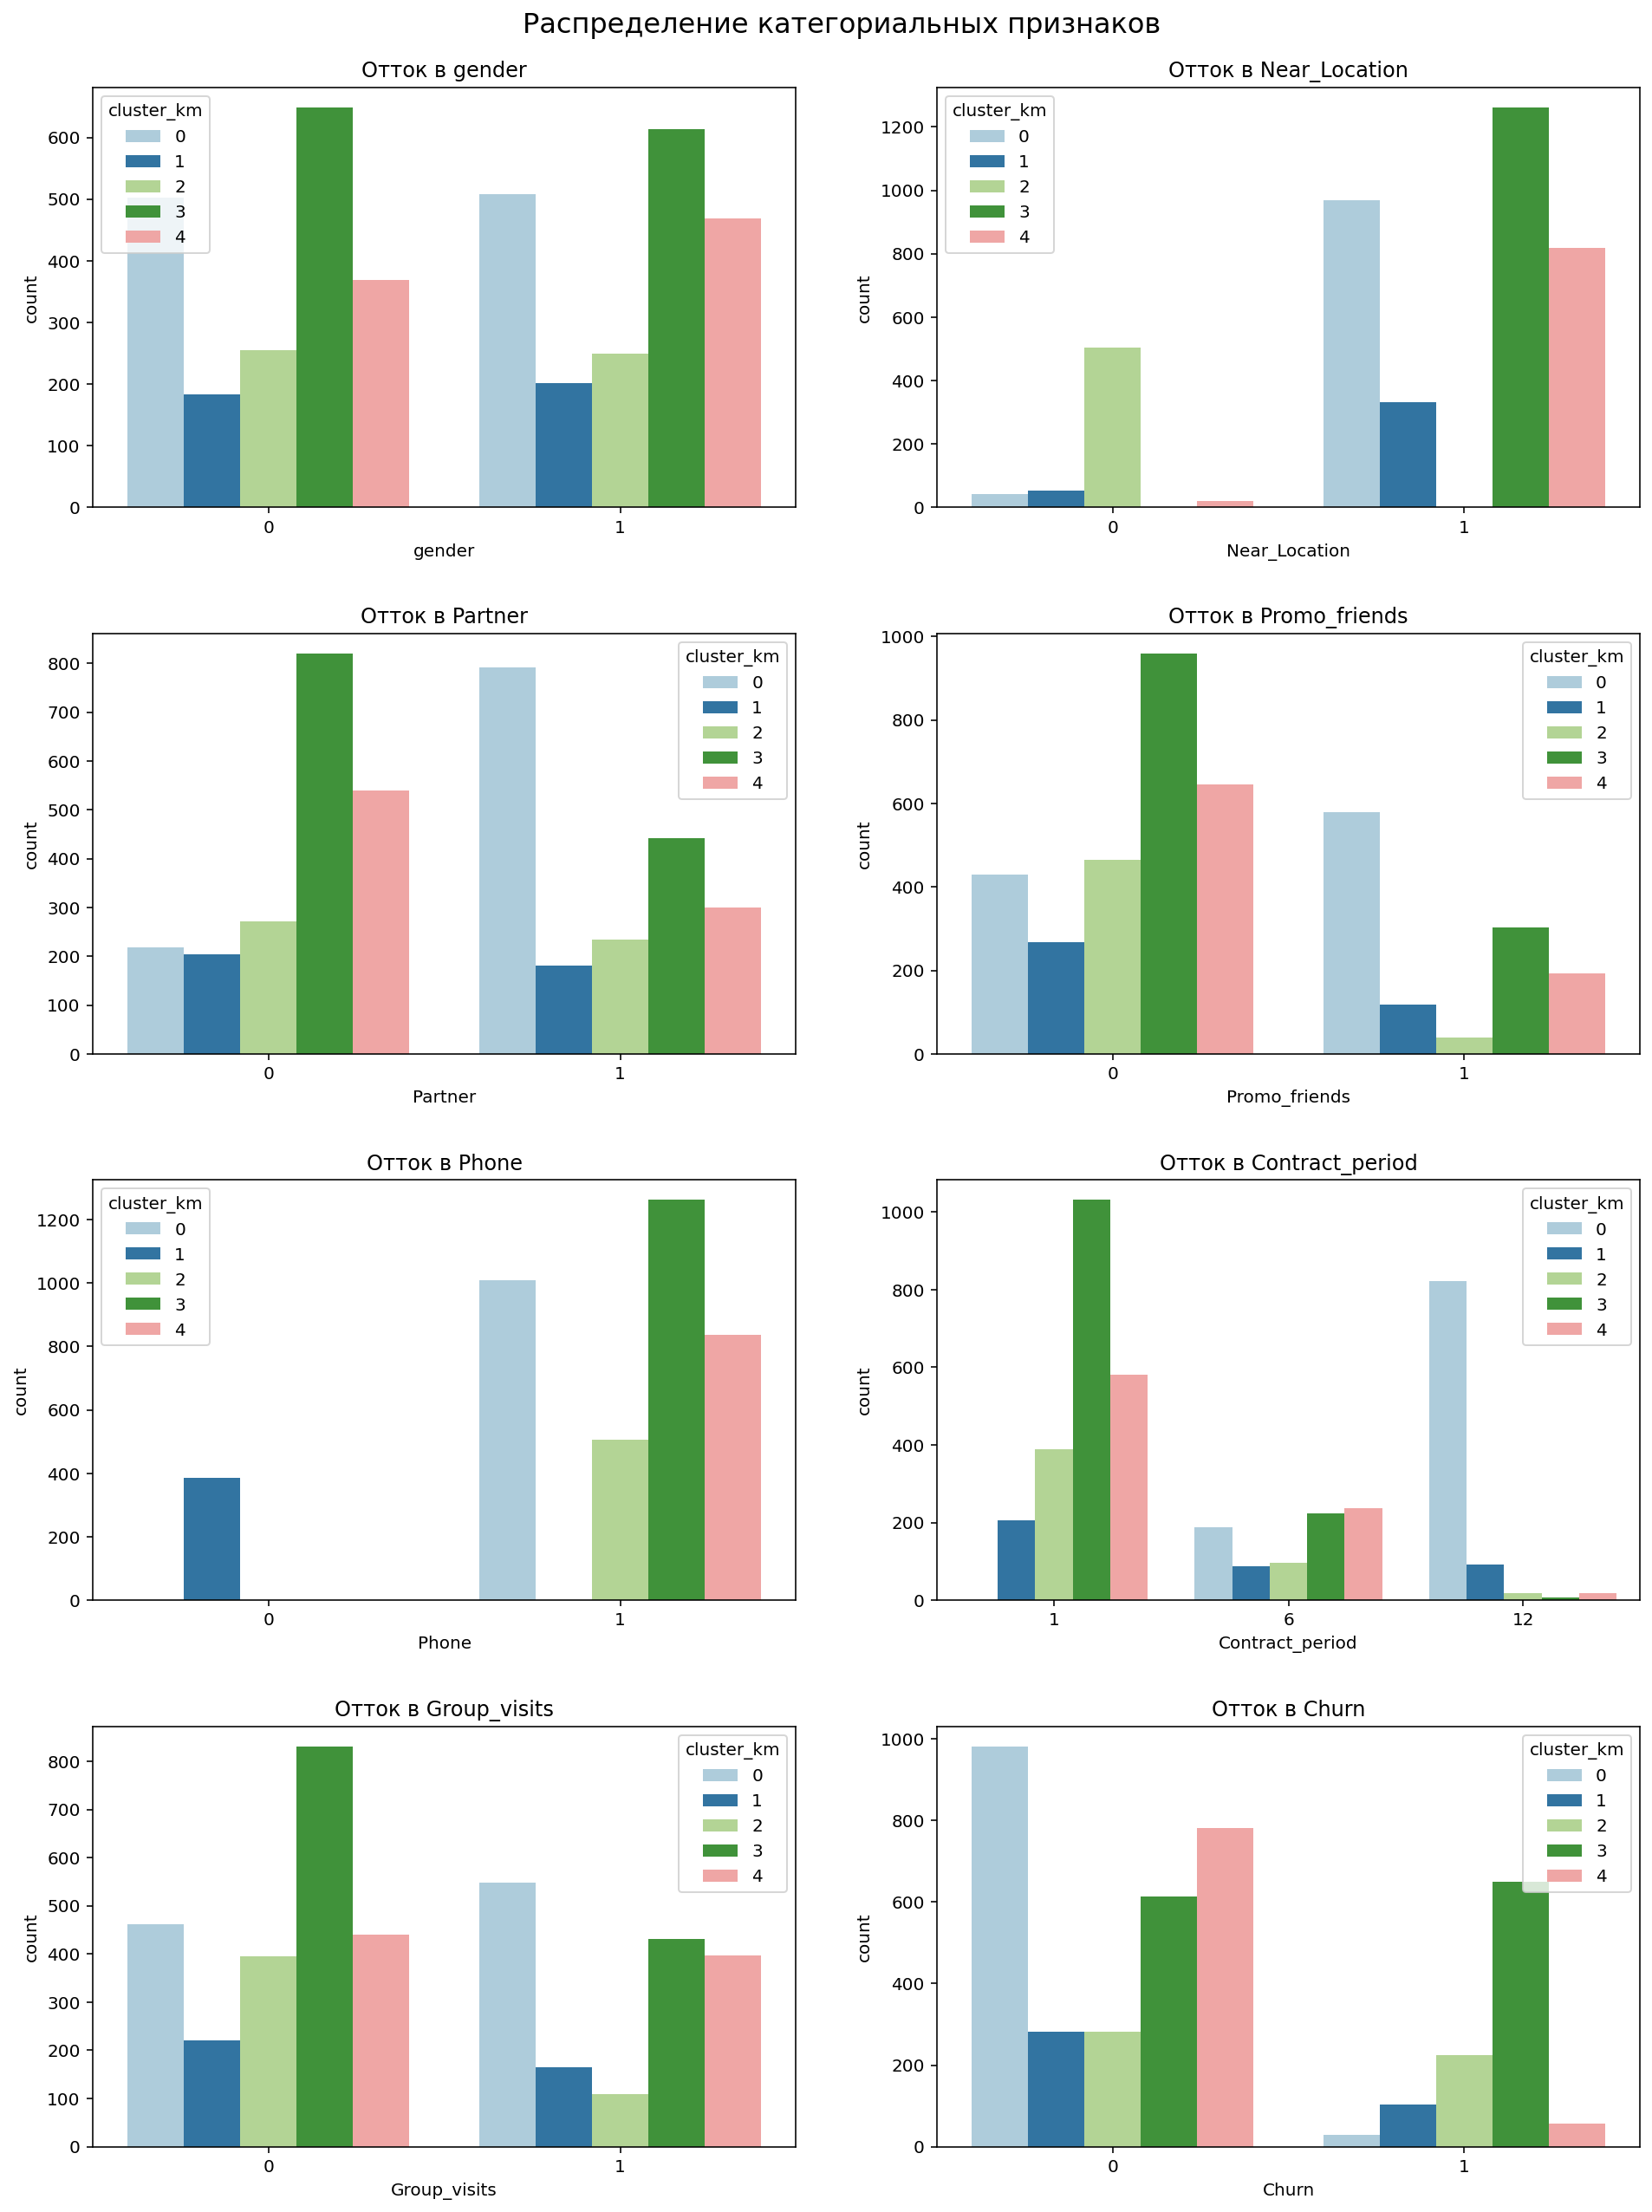

In [32]:
# распределение категориальных признаков gym_churn_cat_cl для кластеров

# числа строк и столбцов в матрице subplot
num_features = len(gym_churn_cat_cl.columns[:-1])  # Количество признаков
num_cols = 2
num_rows = (num_features + num_cols - 1) // num_cols  # Рассчитываем количество строк

# матрица subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 20))
fig.subplots_adjust(wspace=0.2, hspace=0.3, top=0.95)

# Перебор признаков и построение графиков boxplot с использованием hue
for i, column in enumerate(gym_churn_cat_cl.columns[:-1]):  # Исключаем последний столбец с кластерами
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.countplot(data=gym_churn_cat_cl, x=column, hue='cluster_km', palette='Paired', ax=ax)
    ax.set_title(f'Отток в {column}')
fig.suptitle('Распределение категориальных признаков', fontsize=16)
plt.show()

- По таблице и по графикам наибольшая доля оттока у Кластеров: 3 (51%), 2 (44%), 1(27%). Минимальное у кластеров 0(3%) 4(7%).

**1. Не надежные (сильный отток) Кластеры 3 (51%), 2 (44%), их характерные признаки:**
* Все клиенты из Кластера 2 не проживают и не работают в том районе где находиться фитнес-центр. Возможно эта одна из основных причин оттока этого кластера.
* Кластер 3, большая часть его клиентов берент абонемент на 1мес (1,98 средняя).
* Чем меньше люди ходят на групповые занятия, тем больше вероятность оттока. Кластер 2-21%, Кластер 3-34%.
* Кластеры 2 и 3 самые молодые (~28лет), и наверное более требовательные.
* Ну и закономерно конечто у Кластеров 3,2 чем больше процент оттока тем: меньше "Лайфтайм", меньше кол-во часов за неделю в целом, а также кол-во часов за последний месяц еще более ярко выражено меньше. Желательно чтобы у человек ходил в зал не менее 2ух раз в неделю.


**2. Средней надежности Кластеры 1 (27%) , их характерные признаки:**
*  У всех клиентов из Кластера 1 - не указан мобильный телефон, у всех остальных указан.
* Они живут рядом, в среднем берут на 6мес.


**3. Надежные (нет оттока) Кластеры 0 (3%) 4 (7%), их характерные признаки:**
* Почти все клиенты кластера 0 (самый надежный) являются сотрудниками компаний-партнеров -78%, что дает им скидки. Также в этом кластере самая большая доля клиентов получивших скидку по акции "Приведи друга" 57%.
У них у всех почти абонемент на 12мес. Большая их часть посещает групповые занятия -54%
* Кластеры 0 и 3 потратили немного больше денег на доп.услуги (кафе, спорттовары, косметический и массажный салон) на ~20% чем кластеры 2,3 (где большой отток).

## 6. Выводы и базовые рекомендации по работе с клиентами

**6.1 Общие рекомендации чтобы меньше было оттока:**
1. Предлагать лучшие условия для абонемента 12мес, может быть скидки. Чем на большее кол-во месяцев берут, тем меньше оттока.
2. Клиентам которые не проживают и не работают в том районе где находиться фитнес-центр также давать скидки.
3. Предлагать больше групповых занятий, разнообразить виды. Чем больше люди хотят на групповые занятия, тем меньше вероятность оттока.
4. Чем моложе клиент (<29), тем более вежливо и обходительнее надо с ним общаться, отвечать на все его вопросы. У более молодых клиентов больше вероятность оттока.
5. Наблюдать метрику за последний месяц чтобы клиент ходил в зал не менее 2ух раз в неделю, если будет ходить меньше уже повышается вероятность оттока. Напоминать зож-статьями, предлагать ему групповые занятия разные, завлекать скидками на доп. услуги (кафе, спорттовары, косметический и массажный салон).
6. Просить указывать телефон. Если не указан телефон, то вы не можете с ним связаться, и вероятность оттока 27%.

**6.2 Выводы по общей информации о данных**
- М/Ж поровну практически 50/50
- Очень большая часть клиентов 85% проживает или работает в районе, где находится фитнес-центр;
- Клинетов от компании-партнёров -50/50 распределение
- Людей которые пришли по акции «приведи друга» их примерно 1/3
- Телефон указан у большинства 90%
- Возраст нормально распределен, среднее - 29лет
- 'Lifetime' Время жизни клиента (в месяцах) - распределние ближе к 0-1
- 'Contract_period' — длительность текущего действующего абонемента (месяц - почти половина берут на 1мес, 6 месяцев-~25%, год -~25%);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах). Много у кого заканчивается абонемент кумулятивно, это логично потому что есть спуски после 1 и 6 месяцев. Если у большинства абонемент на 1мес то на этом графике их тоже большинство.
- 'Group_visits' — факт посещения групповых занятий ~40%
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента - Среднее 1,88раза в неделю, но визуально еще видно отдельный столбик тех у кого 0 раз.
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц. Тут график похож на предыдущий Тотал, но тут более ярко-выраженная категория людей у которых 0 посещений за месяц.
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон. Смещение к 130-140
- 'Churn' — факт оттока в текущем месяце. ~27%

**6.3 Выводы по моделям и по метрикам**
1. Для бинарной классификации Логистическая регрессия, Случайный лес- не страдают от скоррелированных(мультиколлениарных) признаков, даже наоборот если удалить скореллированные признаки то модель будет хуже предсказывать.
2. Самые лучше метрики получились у Логистической регрессии с добавлением stratify=y Стратификация (равномерное распределение).
- Метрики Логистической регрессии:
- Accuracy (Доля правильных ответов): 0.935
- Precision (Точность): 0.896
- Recall (Полнота): 0.854
- F1 (Мера, баланс между метриками): 0.874
- ROC_AUC (Площадь под кривой): 0.978

У лучшей модели по всем метрикам Логистическая регрессия, самые важные параметры влияющие на отток клиента: 

1. Средняя частота посещений в неделю за предыдущий месяц. 
2. 'Lifetime' — время с момента первого обращения в фитнес-центр 
3. Средняя частота посещений в неделю за все время с начала действия абонемента
* У модели Случайный лес тройка такая же, только порядок немного другой.

**6.4 Выводы по кластерам**
- По таблице и по графикам наибольшая доля оттока у Кластеров: 3 (51%), 2 (44%), 1(27%). Минимальное у кластеров 0(3%) 4(7%).
- Если вы наблюдаете у клинетов нижеперечисленные признаки характерные Кластерам 2 и 3, то с этими клиентами надо больше поработать, завлечь, дать больше скидку, чтобы уменьшить отток:

**1. Не надежные (сильный отток) Кластеры 3 (51%), 2 (44%), их характерные признаки:**
* Все клиенты из Кластера 2 не проживают и не работают в том районе где находиться фитнес-центр. Возможно эта одна из основных причин оттока этого кластера.
* Кластер 3, большая часть его клиентов берент абонемент на 1мес (1,98 средняя).
* Чем меньше люди ходят на групповые занятия, тем больше вероятность оттока. Кластер 2-21%, Кластер 3-34%.
* Кластеры 2 и 3 самые молодые (~28лет), и наверное более требовательные.
* Ну и закономерно конечто у Кластеров 3,2 чем больше процент оттока тем: меньше "Лайфтайм", меньше кол-во часов за неделю в целом, а также кол-во часов за последний месяц еще более ярко выражено меньше. Желательно чтобы у человек ходил в зал не менее 2ух раз в неделю.


**2. Средней надежности Кластеры 1 (27%) , их характерные признаки:**
*  У всех клиентов из Кластера 1 - не указан мобильный телефон, у всех остальных указан.
* Они живут рядом, в среднем берут на 6мес.


**3. Надежные (нет оттока) Кластеры 0 (3%) 4 (7%), их характерные признаки:**
* Почти все клиенты кластера 0 (самый надежный) являются сотрудниками компаний-партнеров -78%, что дает им скидки. Также в этом кластере самая большая доля клиентов получивших скидку по акции "Приведи друга" 57%.
У них у всех почти абонемент на 12мес. Большая их часть посещает групповые занятия -54%
* Кластеры 0 и 3 потратили немного больше денег на доп.услуги (кафе, спорттовары, косметический и массажный салон) на ~20% чем кластеры 2,3 (где большой отток).